In [1]:
import os
import argparse
import json
import glob
import nibabel as nib
import numpy as np
import pandas as pd 
import matplotlib as plt
import matplotlib.pyplot as pltpy
from matplotlib.backends.backend_pdf import PdfPages
import seaborn
import math
#import plotnine as p9
try :
    import seaborn as sns
except : 
    ! pip install seaborn
    import seaborn as sns

from skimage.util import montage 
from skimage.transform import rotate
try : 
    import openxyl
except : 
    ! pip install openpyxl

%matplotlib inline
try :
    from brainstat.datasets import fetch_mask, fetch_template_surface,fetch_parcellation
except : 
    ! pip install brainstat
    from brainstat.datasets import fetch_mask, fetch_template_surface,fetch_parcellation
from itertools import combinations
from brainspace.datasets import load_mask
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from brainspace.mesh.mesh_operations import combine_surfaces
from brainspace.utils.parcellation import map_to_labels
from brainspace.vtk_interface import wrap_vtk, serial_connect
from vtk import vtkPolyDataNormals
from brainstat.datasets import fetch_mask, fetch_template_surface,fetch_parcellation
from brainspace.mesh.mesh_io import read_surface
from IPython.display import display,Image
import statsmodels.api as sm
from brainstat.stats.terms import FixedEffect
from brainstat.stats.terms import MixedEffect
from brainstat.stats.SLM import SLM
import scipy.stats as stats
from scipy.stats import ttest_ind
import laBIBILaRORO as lbr
from importlib import reload


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
La bibil à RORO loaded


In [2]:
pial_left, pial_right = fetch_template_surface("fsaverage5",layer="pial",join=False)
inflated_left, inflated_right = fetch_template_surface("fsaverage5",layer="inflated",join=False)
pial_combined = fetch_template_surface("fsaverage5", join=True)
mask = fetch_mask("fsaverage5")
glasser = fetch_parcellation("fsaverage5", "glasser", 360)

pial_left_fslr32k, pial_right_fslr32k = fetch_template_surface("fslr32k", join=False)
inflated_left_fslr32k,inflated_right_fslr32k = fetch_template_surface("fslr32k",layer="inflated", join=False)
vinflated_left_fslr32k,vinflated_right_fslr32k = fetch_template_surface("fslr32k",layer="vinflated", join=False)
pial_combined_fslr32k = fetch_template_surface("fslr32k", join=True)
mask_fslr32k = fetch_mask("fslr32k")
glasser_fslr32k = fetch_parcellation("fslr32k", "glasser", 360)

In [3]:
file_path = '/NAS/tupac/romain/MNI_Glasser_extHCP_etc/HCP-MMP1_UniqueRegionList.csv'
df_exthcp = pd.read_csv(file_path)
#print(df_exthcp.head())  # Affiche les premières lignes du DataFrame

file_path = '/NAS/tupac/romain/MNI_Glasser_extHCP_etc/Glasser_2016_Table-1.xlsx'
df_gla = pd.read_excel(file_path)
#df_gla

#attention entre el numero de regionID et le numero dans numpy ndarray il y aun decalge de 20 l'un recommence à 181 l'autre à 200
#mapping_dict = dict(zip(df_exthcp['regionID'], df_exthcp['Cortex_ID']))
mapping_dict = dict(zip(df_exthcp.index.values+1, df_exthcp['Cortex_ID']))

mapping_dict[0] = 0
def map_values(value):
    return mapping_dict.get(value, 400)  # Remplacer 0 par une autre valeur par défaut si nécessaire

for key in mapping_dict.keys():
    # Vérifier si la clé est supérieure à 180
    if key > 180:
        # Ajouter 22 à la valeur correspondante
        mapping_dict[key] += 22

# Utiliser np.vectorize pour appliquer la fonction de correspondance
vectorized_map = np.vectorize(map_values)
glasser_fslr32k_exthcp = vectorized_map(glasser_fslr32k)

#verif 
#set(mapping_dict.values())

## Affiche des infos principales

In [4]:
print(f"number of points in fslr32k = {glasser_fslr32k.shape[0]}, left and right = {inflated_left_fslr32k.GetPoints().shape[0]}")
print(f"number of points in fsaverage = {glasser.shape[0]}, left and right = {inflated_right.GetPoints().shape[0]}")
print(f"number of ROI values in glasser = {len(np.unique(glasser))}")
print(f"number of ROI values in HCP extended = {len(np.unique(glasser_fslr32k_exthcp))}")

number of points in fslr32k = 64984, left and right = 32492
number of points in fsaverage = 20484, left and right = 10242
number of ROI values in glasser = 361
number of ROI values in HCP extended = 45


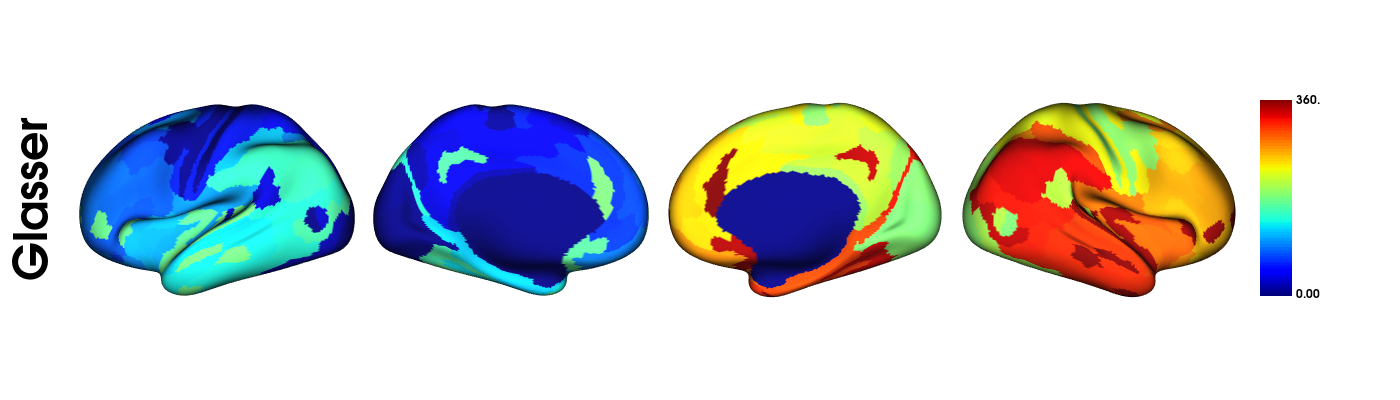

In [5]:
#np.where(np.isin(glasser_fslr32k, [1,4,5,6]),glasser_fslr32k, 0)
plot_hemispheres(vinflated_left_fslr32k,vinflated_right_fslr32k,glasser_fslr32k, color_bar=True,
        label_text=["Glasser"], cmap="jet", 
        embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)

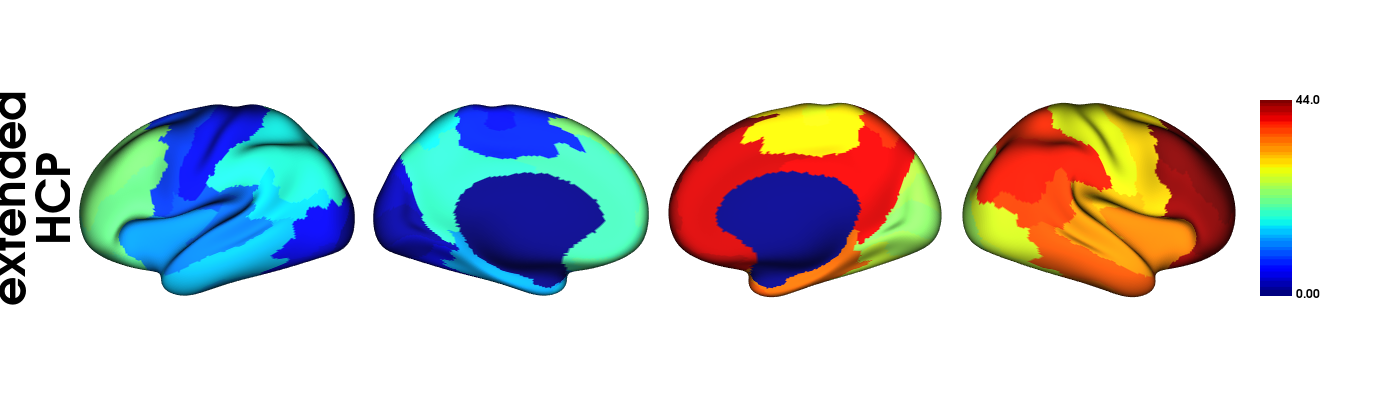

In [6]:
#np.where(np.isin(glasser_fslr32k, [1,2,3,4]),glasser_fslr32k, 0)
plot_hemispheres(vinflated_left_fslr32k,vinflated_right_fslr32k,glasser_fslr32k_exthcp, color_bar=True,
        label_text=["extended\nHCP"], cmap="jet", 
        embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)

# Chargement des données propre à l'étude

In [7]:
STUDY_PATH=os.path.join("/NAS","fatmike","Protocoles_3T","Neurosclerodermie")
DERIVATIVE_PATH=os.path.join(STUDY_PATH,"data","bids","derivatives")
#SCRIPT_PATH=os.path.join(STUDY_PATH,'scripts')
#LOG_PATH=os.path.join(SCRIPT_PATH,'log')
DATA_FILE=os.path.join(STUDY_PATH,'neurosclerodermie_participants.xlsx')

In [8]:
#CLIData['Groupe_NAME'].unique()
palette = {
    'NoCogNoPsy': '#1f77b4',  # Bleu
    'CogNoPsy': '#ff7f0e',  # Orange
    'CogPsy': '#2ca02c',   # Vert
    'NoCogPsy': '#d62728',     # Rouge
    'CTRL' : '#9467bd' # Violet
}

In [9]:
var4Cov=['AGE','IMC']

In [10]:
CLIData = pd.read_excel(DATA_FILE,index_col=0,engine='openpyxl')
CLIData.head()

,Groupe,AGE,IMC
SUBJID,,,
P0101,0,63,32.0
P0102,1,57,26.0
P0104,3,51,33.0
P0105,2,59,30.0
P0107,0,63,18.0


In [11]:
# Calculer la moyenne de la colonne IMC
mean_imc = CLIData['IMC'].mean()

# Imputer les valeurs manquantes avec la moyenne
CLIData['IMC'].fillna(mean_imc, inplace=True)

# Afficher les premières lignes pour vérifier
print(CLIData.head())

        Groupe  AGE   IMC
SUBJID                   
P0101        0   63  32.0
P0102        1   57  26.0
P0104        3   51  33.0
P0105        2   59  30.0
P0107        0   63  18.0


/tmp/ipykernel_2328727/3260783410.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  CLIData['IMC'].fillna(mean_imc, inplace=True)


In [12]:
# Créer la colonne GROUPE_NAME en fonction des valeurs de GROUPE
def map_group_name(group):
    if group == 0:
        return 'NoCogNoPsy'
    elif group == 1:
        return 'CogNoPsy'
    elif group == 2:
        return 'NoCogPsy'
    elif group == 3:
        return 'CogPsy'
    elif group == 4:
        return 'CTRL'
    else:
        return 'Unknown'

CLIData['Groupe_NAME'] = CLIData['Groupe'].apply(map_group_name)

# Afficher le DataFrame pour vérifier les résultats
print(CLIData.head())


        Groupe  AGE   IMC Groupe_NAME
SUBJID                               
P0101        0   63  32.0  NoCogNoPsy
P0102        1   57  26.0    CogNoPsy
P0104        3   51  33.0      CogPsy
P0105        2   59  30.0    NoCogPsy
P0107        0   63  18.0  NoCogNoPsy


# Cortical thickness

In [13]:
valCT = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in range(5, 26, 10)}
for smoothing_fwhm in range(5, 26, 10):
    print(f"Smoothing FWHM: {smoothing_fwhm} mm")
    for elt in CLIData.index:
        sub = f"sub-{str(elt)}"
        path_file_lh = os.path.join(DERIVATIVE_PATH, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + f"_ses-1_hemi-L_surf-fsaverage5_label-thickness_sm{smoothing_fwhm}.func.gii")
        path_file_rh = os.path.join(DERIVATIVE_PATH, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + f"_ses-1_hemi-R_surf-fsaverage5_label-thickness_sm{smoothing_fwhm}.func.gii")
        
        if os.path.exists(path_file_lh) and os.path.exists(path_file_rh):
            tmp_rh = nib.load(path_file_rh) 
            tmp_lh = nib.load(path_file_lh)
            volumeG1 = np.concatenate([tmp_lh.darrays[0].data, tmp_rh.darrays[0].data], axis=0)
            valCT[f"sm_{smoothing_fwhm}"].append(volumeG1)
        else:
            print(sub)


Smoothing FWHM: 5 mm
Smoothing FWHM: 15 mm
Smoothing FWHM: 25 mm


In [14]:
CLIData.loc[CLIData['Groupe'] == 2]

,Groupe,AGE,IMC,Groupe_NAME
SUBJID,,,,
P0105,2,59,30.0,NoCogPsy
P0111,2,56,43.0,NoCogPsy
P0116,2,35,37.0,NoCogPsy
P0125,2,54,28.0,NoCogPsy
P0128,2,46,23.0,NoCogPsy
P0130,2,50,19.0,NoCogPsy
P0132,2,56,35.0,NoCogPsy
P0166,2,52,23.0,NoCogPsy
P0173,2,52,21.0,NoCogPsy


figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_NoCogNoPsy_sm5.jpg


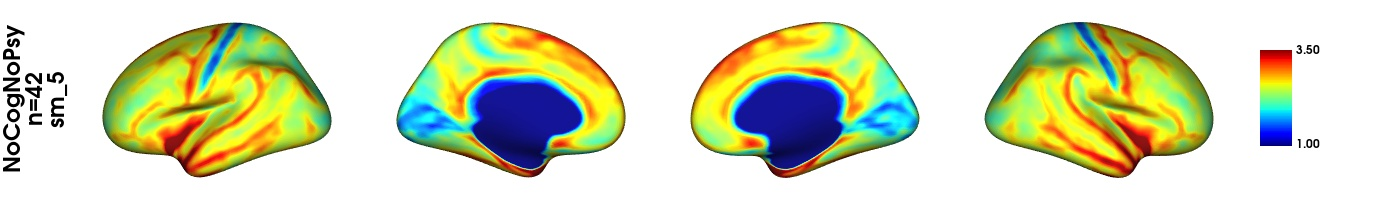

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CogNoPsy_sm5.jpg


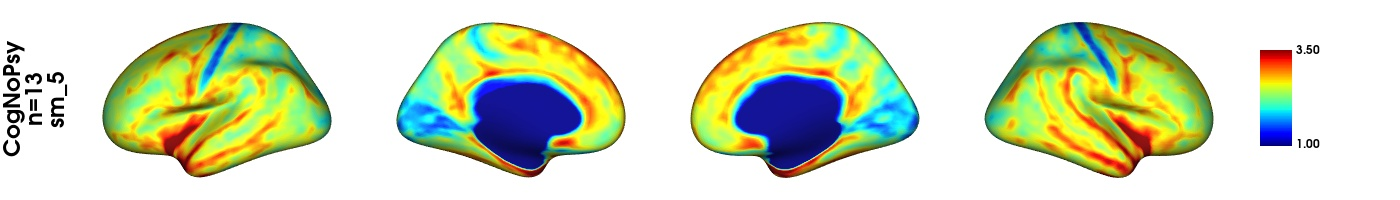

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CogPsy_sm5.jpg


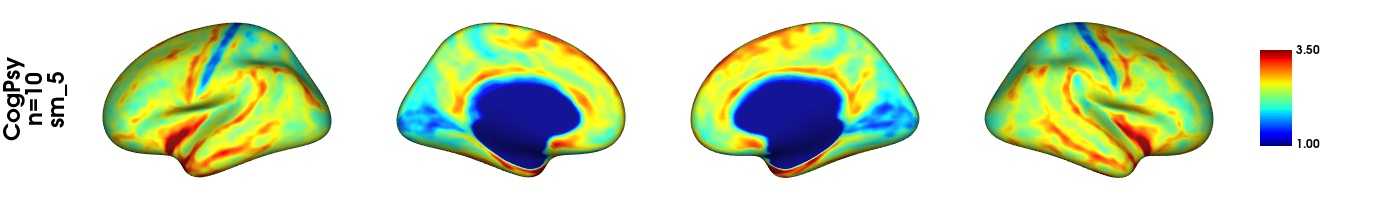

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_NoCogPsy_sm5.jpg


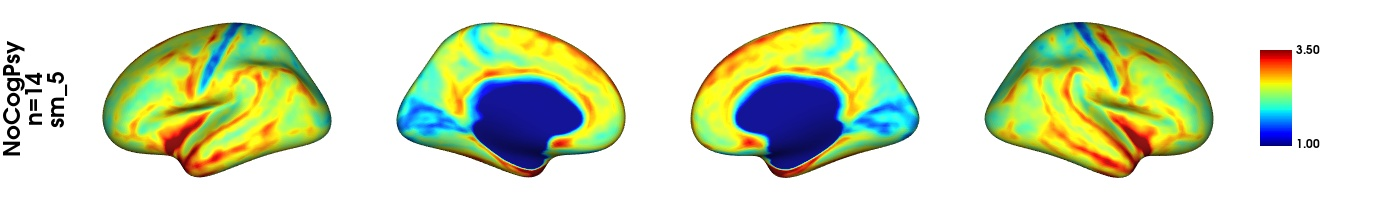

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CTRL_sm5.jpg


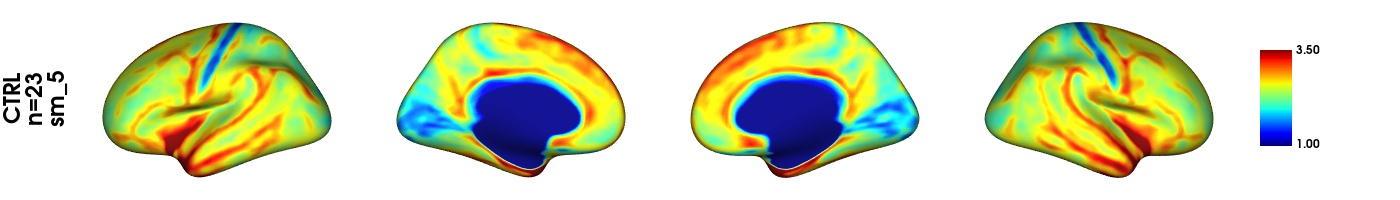

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_NoCogNoPsy_sm15.jpg


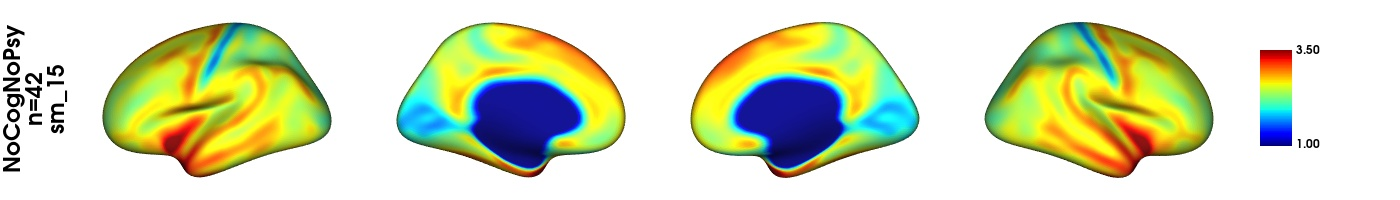

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CogNoPsy_sm15.jpg


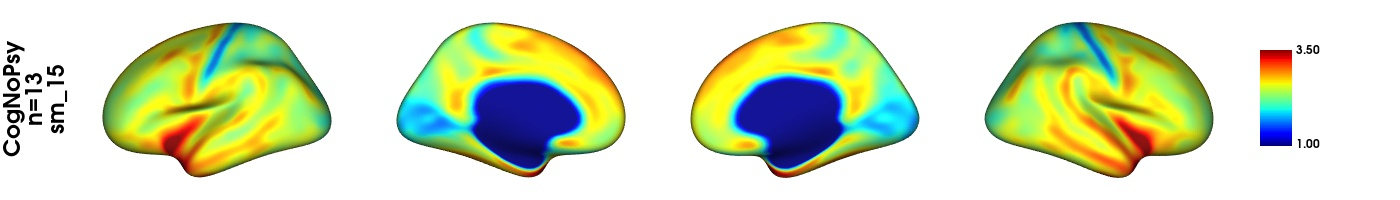

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CogPsy_sm15.jpg


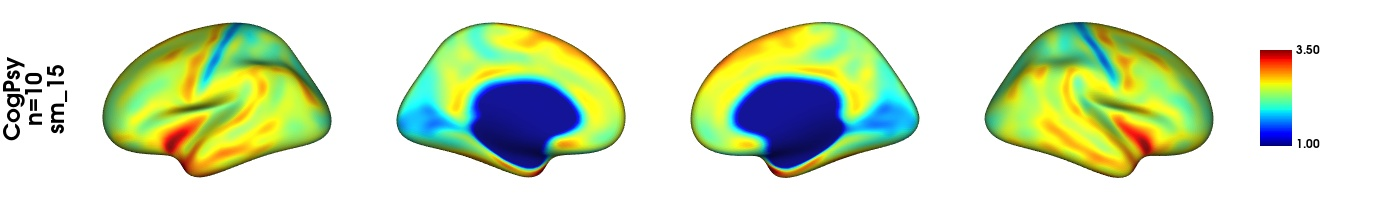

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_NoCogPsy_sm15.jpg


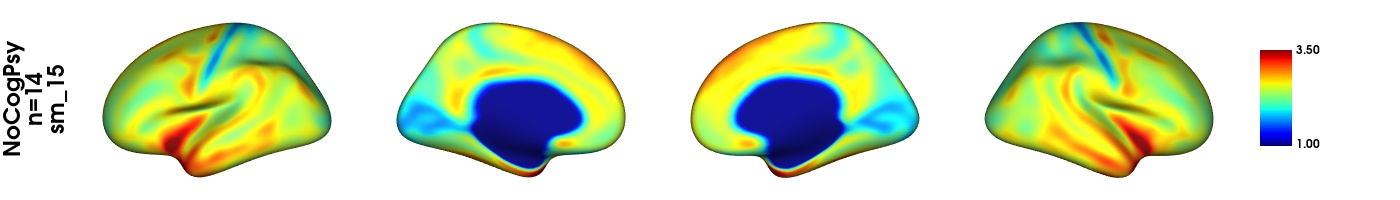

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CTRL_sm15.jpg


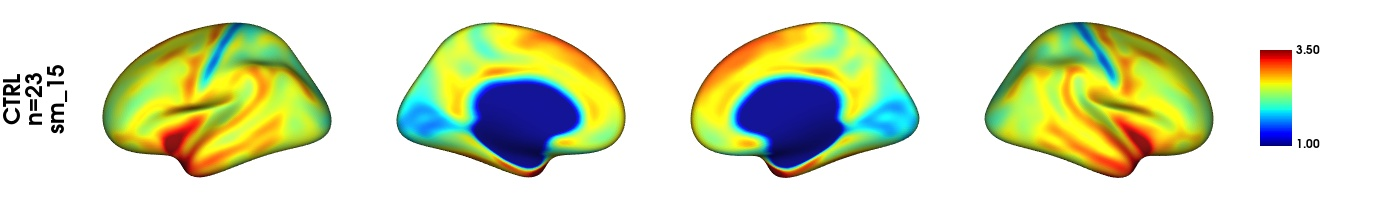

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_NoCogNoPsy_sm25.jpg


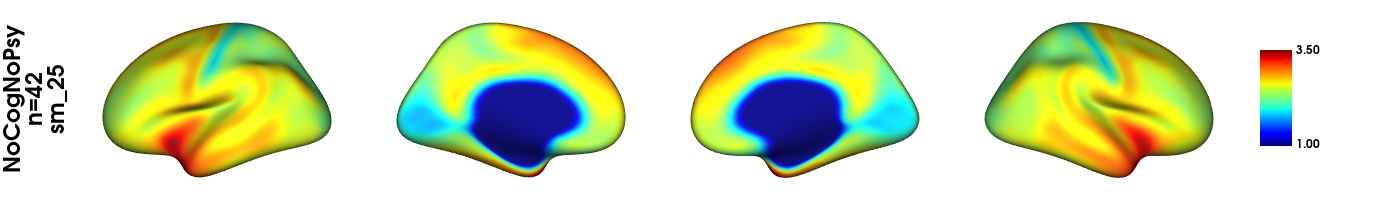

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CogNoPsy_sm25.jpg


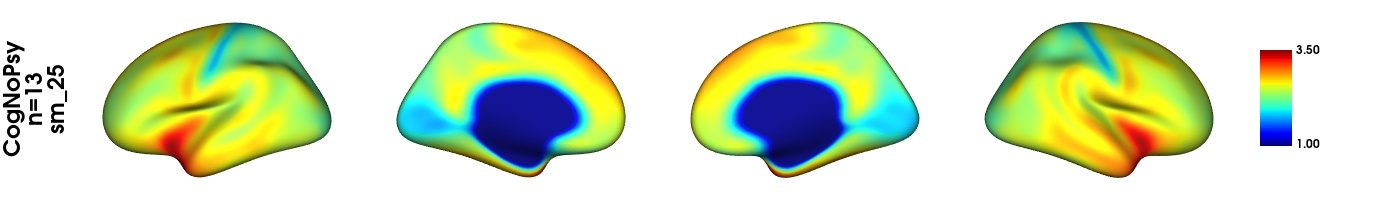

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CogPsy_sm25.jpg


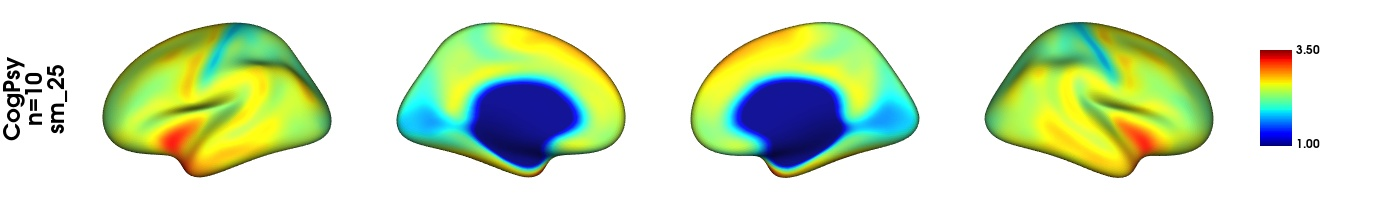

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_NoCogPsy_sm25.jpg


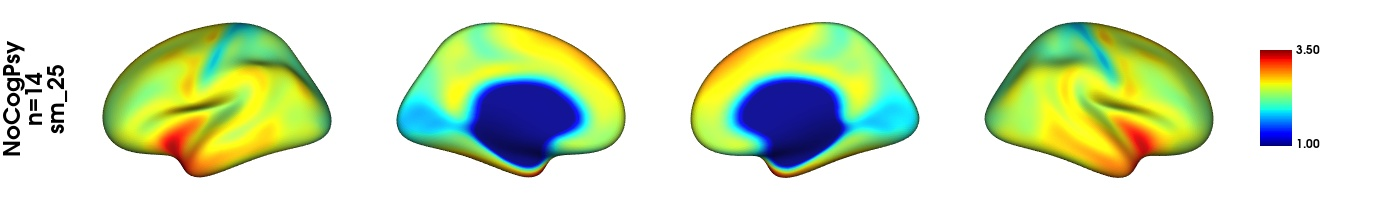

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CTSurface_CTRL_sm25.jpg


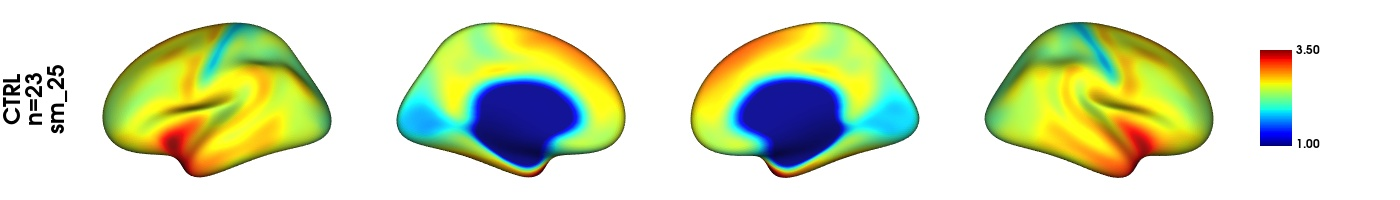

In [19]:
for smoothing_fwhm in range(5, 26, 10): #chain([11], range(15, 31, 5)):
        for gp in CLIData['Groupe_NAME'].dropna().unique():
                figure_title=os.path.join(STUDY_PATH,"screenshots",f"CTSurface_{gp}_sm{smoothing_fwhm}.jpg")
                df_etude1_CT = pd.DataFrame(np.array(valCT[f"sm_{smoothing_fwhm}"]), index=CLIData.index)       
                df_tmp_gp=df_etude1_CT.loc[CLIData['Groupe_NAME'] == gp]
                plot_hemispheres(inflated_left, inflated_right,np.mean(df_tmp_gp,axis=0).values, color_bar=True, color_range=(1, 3.5),
                        label_text=[f"{gp}\nn={len(df_tmp_gp)}\nsm_{smoothing_fwhm}"], cmap="jet", embed_nb=True, size=(1400, 200), zoom=1.45,
                        nan_color=(0.7, 0.7, 0.7, 1), transparent_bg=False,cb__labelTextProperty={"fontSize": 12}, interactive=True,screenshot=True, offscreen=False,filename=figure_title)
                print(f"figure_title : {figure_title}")                        
                display(Image(filename=figure_title))

# Curvature

In [15]:
valCurv = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in range(5, 26, 10)}
for smoothing_fwhm in range(5, 26, 10):
    print(f"Smoothing FWHM: {smoothing_fwhm} mm")
    for elt in CLIData.index:
        sub = f"sub-{str(elt)}"
        path_file_lh = os.path.join(DERIVATIVE_PATH, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + f"_ses-1_hemi-L_surf-fsaverage5_label-curv_sm{smoothing_fwhm}.func.gii")
        path_file_rh = os.path.join(DERIVATIVE_PATH, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + f"_ses-1_hemi-R_surf-fsaverage5_label-curv_sm{smoothing_fwhm}.func.gii")
        
        if os.path.exists(path_file_lh) and os.path.exists(path_file_rh):
            tmp_rh = nib.load(path_file_rh) 
            tmp_lh = nib.load(path_file_lh)
            volumeG1 = np.concatenate([tmp_lh.darrays[0].data, tmp_rh.darrays[0].data], axis=0)
            valCurv[f"sm_{smoothing_fwhm}"].append(volumeG1)
        else:
            print(sub)


Smoothing FWHM: 5 mm
Smoothing FWHM: 15 mm
Smoothing FWHM: 25 mm


figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_NoCogNoPsy_sm5.jpg


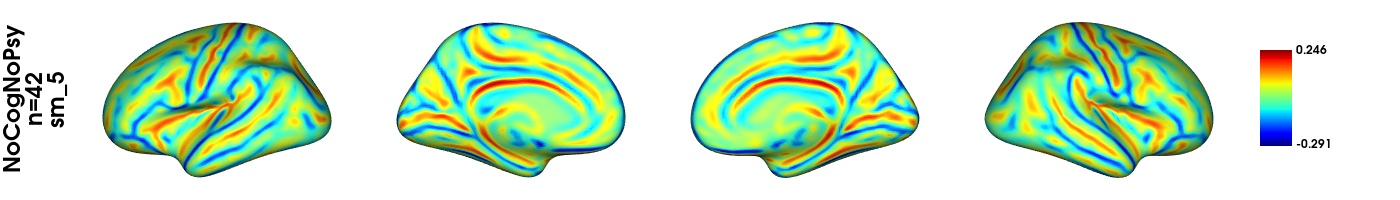

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CogNoPsy_sm5.jpg


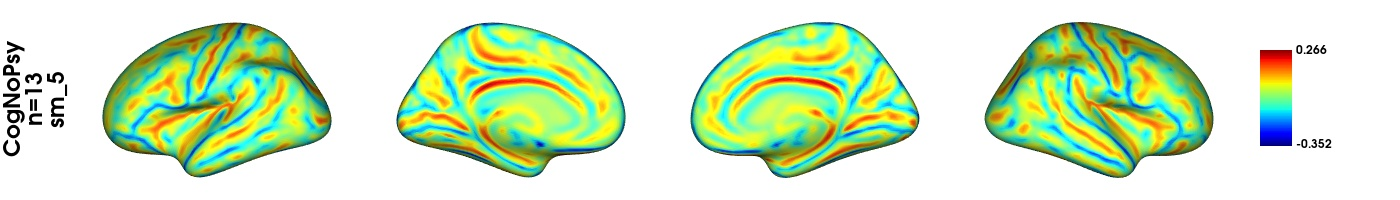

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CogPsy_sm5.jpg


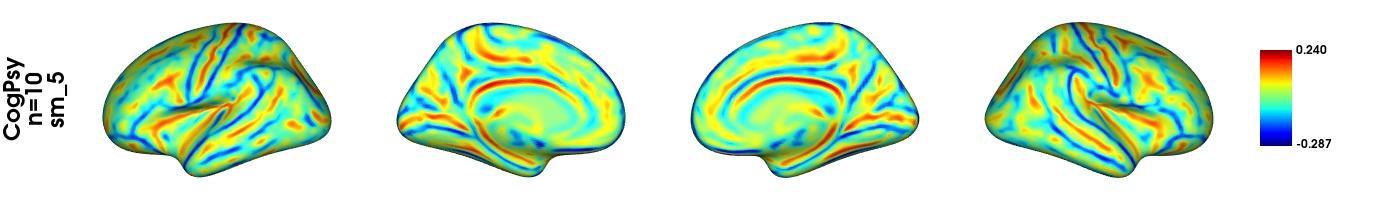

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_NoCogPsy_sm5.jpg


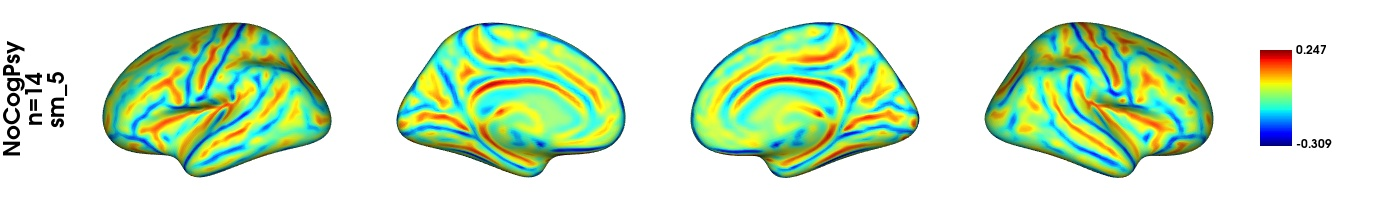

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CTRL_sm5.jpg


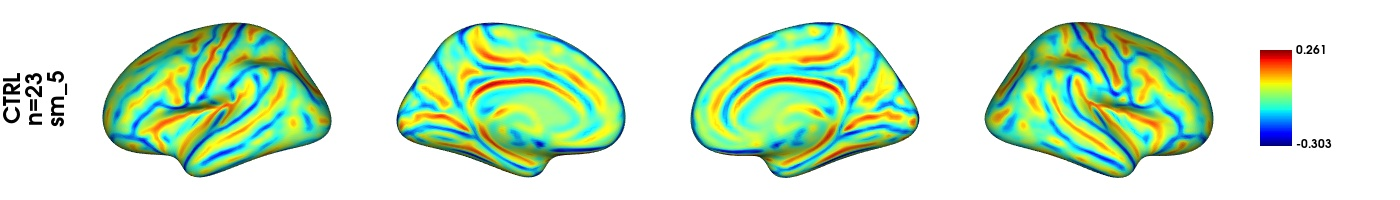

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_NoCogNoPsy_sm15.jpg


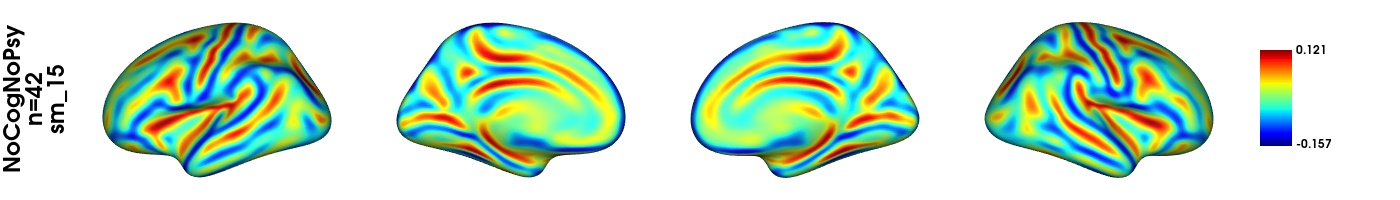

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CogNoPsy_sm15.jpg


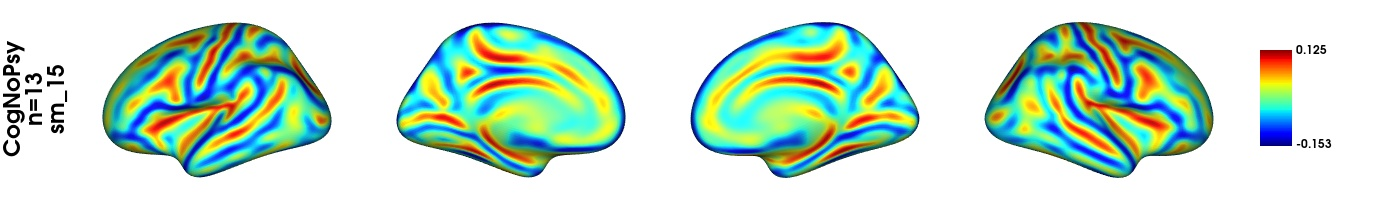

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CogPsy_sm15.jpg


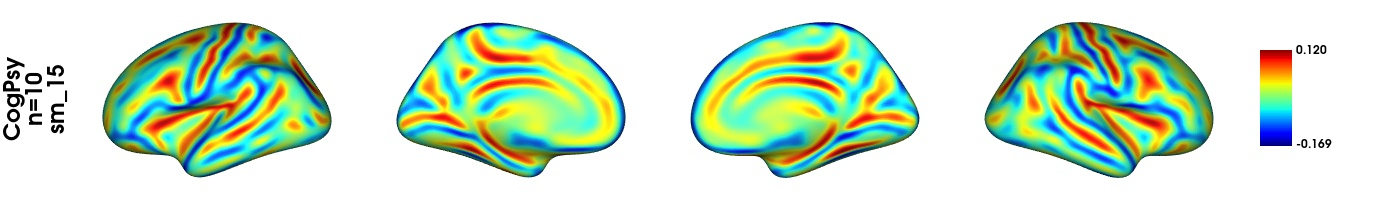

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_NoCogPsy_sm15.jpg


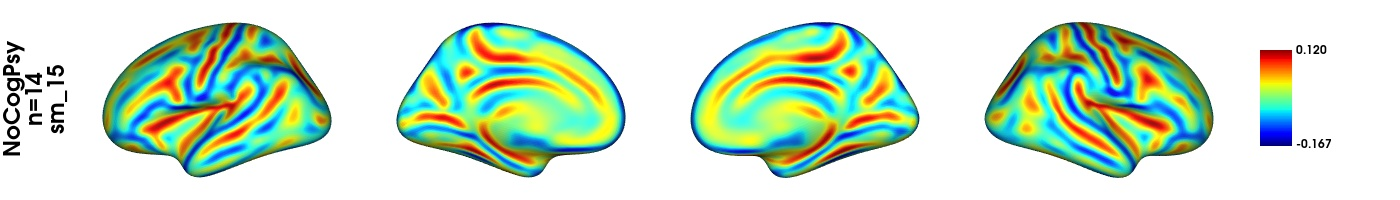

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CTRL_sm15.jpg


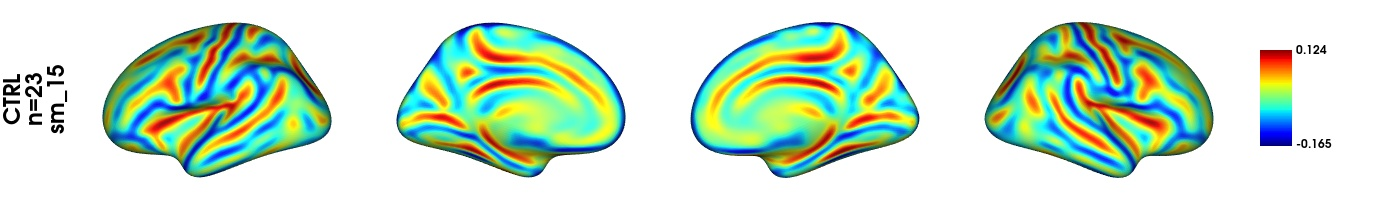

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_NoCogNoPsy_sm25.jpg


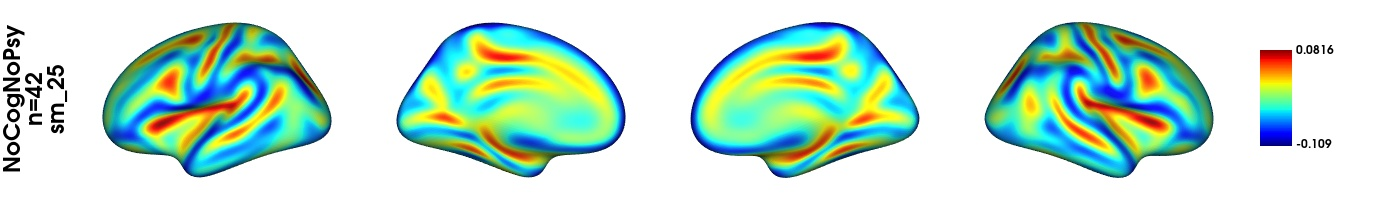

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CogNoPsy_sm25.jpg


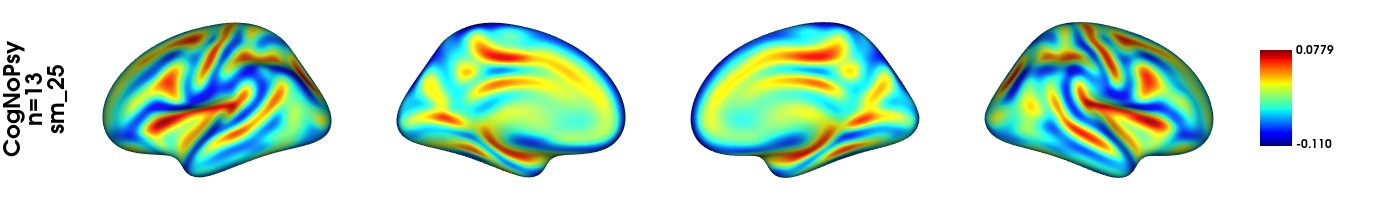

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CogPsy_sm25.jpg


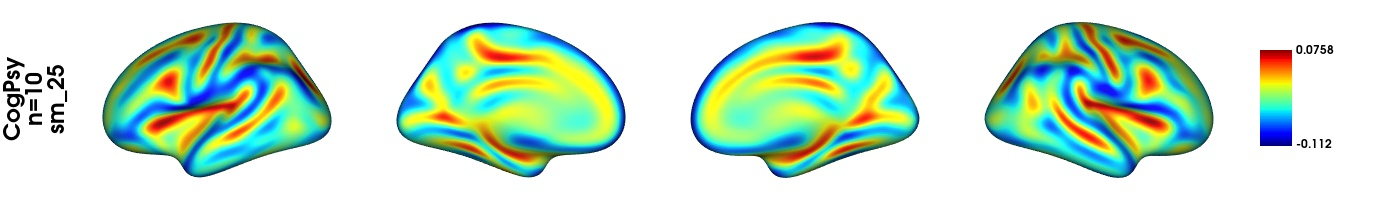

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_NoCogPsy_sm25.jpg


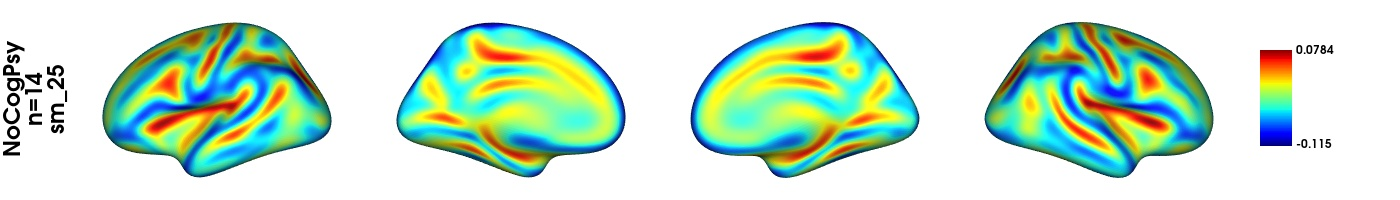

figure_title : /NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/CurvSurface_CTRL_sm25.jpg


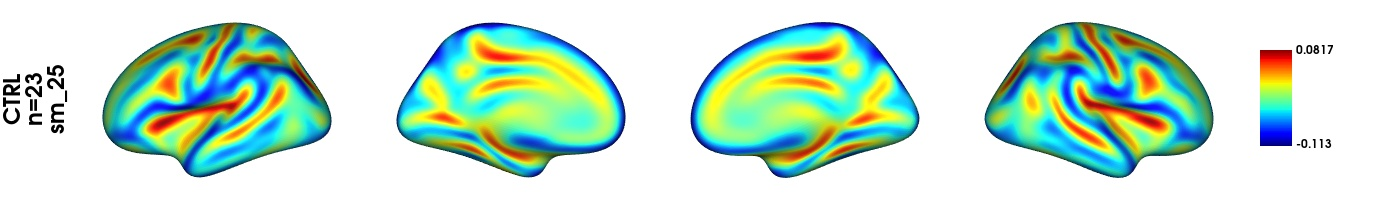

In [21]:
for smoothing_fwhm in range(5, 26, 10): #chain([11], range(15, 31, 5)):
        for gp in CLIData['Groupe_NAME'].dropna().unique():
                figure_title=os.path.join(STUDY_PATH,"screenshots",f"CurvSurface_{gp}_sm{smoothing_fwhm}.jpg")
                df_etude1_CT = pd.DataFrame(np.array(valCurv[f"sm_{smoothing_fwhm}"]), index=CLIData.index)       
                df_tmp_gp=df_etude1_CT.loc[CLIData['Groupe_NAME'] == gp]
                plot_hemispheres(inflated_left, inflated_right,np.mean(df_tmp_gp,axis=0).values, color_bar=True,
                        label_text=[f"{gp}\nn={len(df_tmp_gp)}\nsm_{smoothing_fwhm}"], cmap="jet", embed_nb=True, size=(1400, 200), zoom=1.45,
                        nan_color=(0.7, 0.7, 0.7, 1), transparent_bg=False,cb__labelTextProperty={"fontSize": 12}, interactive=True,screenshot=True, offscreen=False,filename=figure_title)
                print(f"figure_title : {figure_title}")                        
                display(Image(filename=figure_title))

La bibil à RORO loaded
******************************
 smooting à 15
***************************** 
Group comparison between NoCogNoPsy and CogNoPsy
fitting the model
Group comparison between NoCogNoPsy and CogPsy
fitting the model
Group comparison between NoCogNoPsy and NoCogPsy
fitting the model
/NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/sm_15/CTSurface_groupscomparison_NoCogNoPsy_vs_NoCogPsy_contrast0.jpg


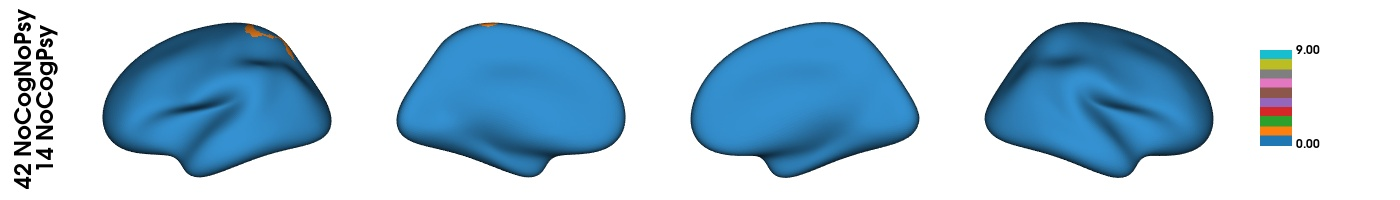

***** 
 clusters infos : 
***** 
     clusid  nverts    resels         P
0       1   148.0  5.263309  0.000254
***** 
 peaks infos : 
***** 
             t  vertid  clusid         P
2   3.993681    3565       1  0.416345
15  3.427679    6534       1  1.822645
21  3.191103    2320       1  3.204339
27  3.038496    8791       1  4.522993
  cluster_1 


/home/romain/SVN/python/romain/laBIBILaRORO.py:352: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_copy,y=name,x=groupUsed, palette=palette_copy,order=palette_copy.keys())


/NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/sm_15/groups_compare_cluster_1_contrast0.png


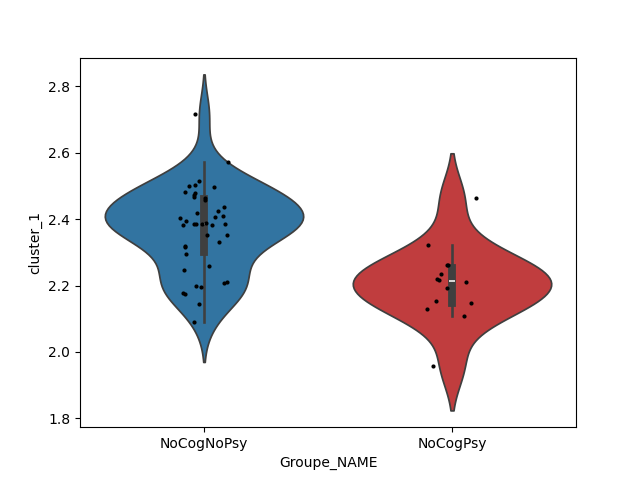

T-Test (oneside) : 4.548 and p_value = 0.000
Group comparison between NoCogNoPsy and CTRL
fitting the model
Group comparison between CogNoPsy and CogPsy
fitting the model
Group comparison between CogNoPsy and NoCogPsy
fitting the model
Group comparison between CogNoPsy and CTRL
fitting the model
Group comparison between CogPsy and NoCogPsy
fitting the model
Group comparison between CogPsy and CTRL
fitting the model
/NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/sm_15/CTSurface_groupscomparison_CogPsy_vs_CTRL_contrast1.jpg


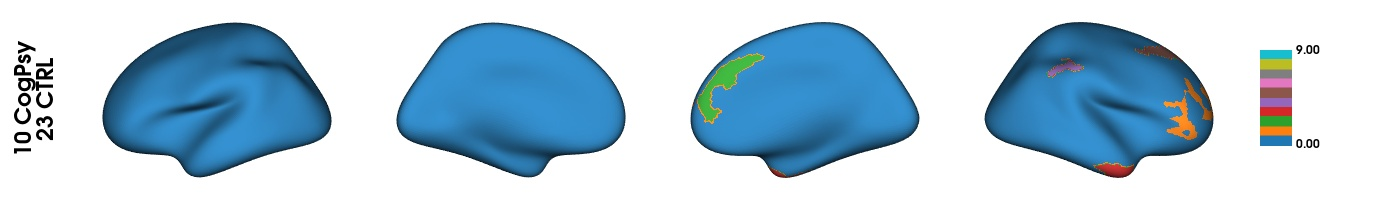

***** 
 clusters infos : 
***** 
     clusid  nverts    resels         P
0       1   249.0  8.867006  0.000029
1       2   152.0  4.569182  0.002277
2       3   162.0  3.852826  0.005960
3       4    83.0  3.661880  0.007819
4       5    82.0  3.519440  0.009617
***** 
 peaks infos : 
***** 
             t  vertid  clusid          P
0   6.227514   18895       5   0.004392
2   4.614322   11236       2   0.212842
3   4.465549   18488       1   0.301756
5   4.418274   17522       1   0.336797
6   4.343126   13199       2   0.401089
8   4.317274   11535       4   0.425658
9   4.308252   14110       3   0.434755
12  3.909272   19952       4   1.073451
15  3.853020   10506       2   1.215695
16  3.778670   12801       3   1.431286
17  3.768538   17275       3   1.462660
19  3.612550   13506       3   2.047584
23  3.535570   14354       1   2.410393
24  3.533342   16275       4   2.421720
28  3.428369   12451       2   3.016007
32  3.352426   10502       1   3.524791
33  3.336454   16466     

/home/romain/SVN/python/romain/laBIBILaRORO.py:352: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_copy,y=name,x=groupUsed, palette=palette_copy,order=palette_copy.keys())


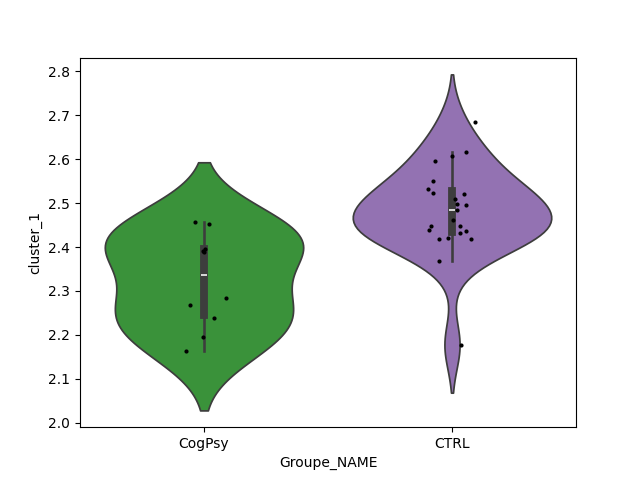

T-Test (oneside) : -3.968 and p_value = 0.001
  cluster_2 


/home/romain/SVN/python/romain/laBIBILaRORO.py:352: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_copy,y=name,x=groupUsed, palette=palette_copy,order=palette_copy.keys())


/NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/sm_15/groups_compare_cluster_2_contrast1.png


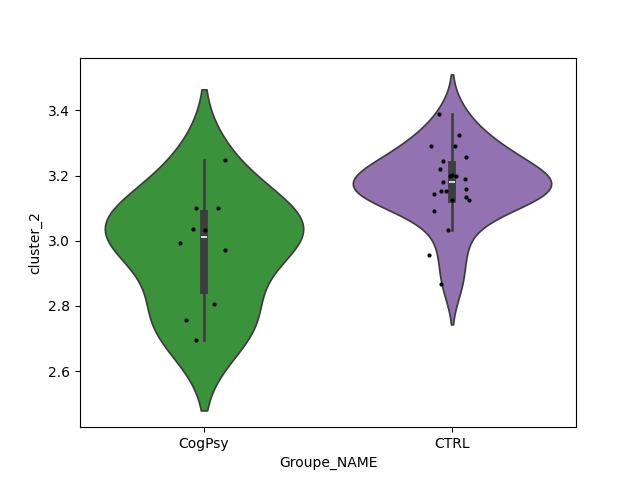

T-Test (oneside) : -3.304 and p_value = 0.006
  cluster_3 


/home/romain/SVN/python/romain/laBIBILaRORO.py:352: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_copy,y=name,x=groupUsed, palette=palette_copy,order=palette_copy.keys())


/NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/sm_15/groups_compare_cluster_3_contrast1.png


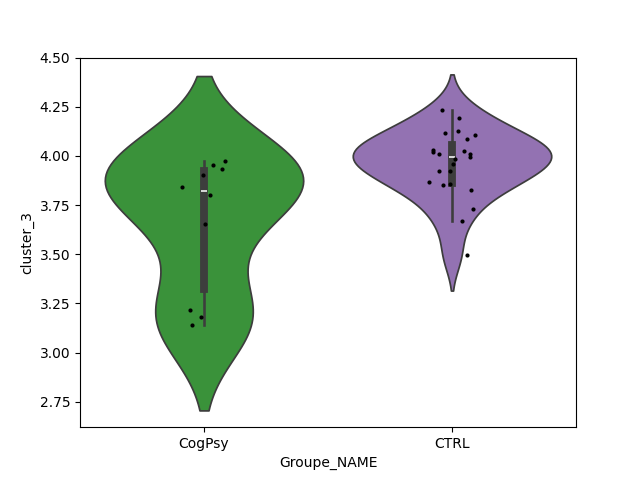

T-Test (oneside) : -2.604 and p_value = 0.025
  cluster_4 


/home/romain/SVN/python/romain/laBIBILaRORO.py:352: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_copy,y=name,x=groupUsed, palette=palette_copy,order=palette_copy.keys())


/NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/sm_15/groups_compare_cluster_4_contrast1.png


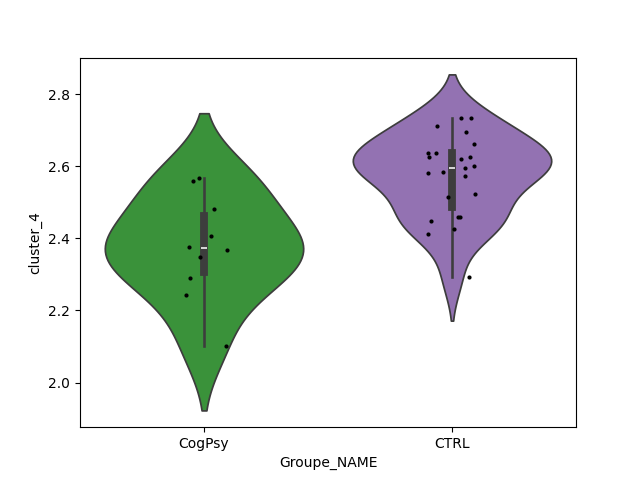

T-Test (oneside) : -3.878 and p_value = 0.002
  cluster_5 


/home/romain/SVN/python/romain/laBIBILaRORO.py:352: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_copy,y=name,x=groupUsed, palette=palette_copy,order=palette_copy.keys())


/NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/sm_15/groups_compare_cluster_5_contrast1.png


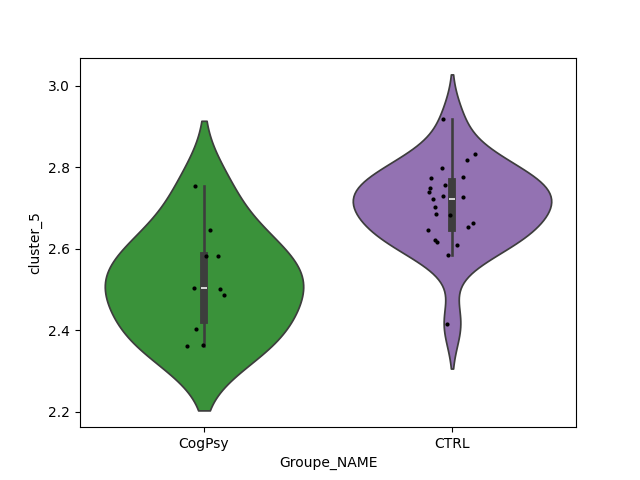

T-Test (oneside) : -4.130 and p_value = 0.001
Group comparison between NoCogPsy and CTRL
fitting the model
/NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/sm_15/CTSurface_groupscomparison_NoCogPsy_vs_CTRL_contrast1.jpg


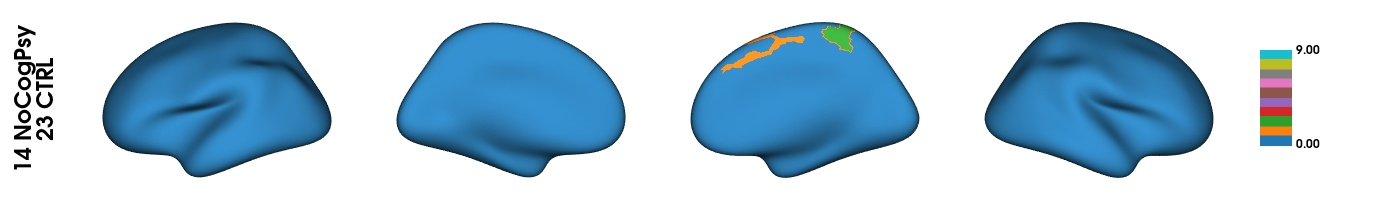

***** 
 clusters infos : 
***** 
     clusid  nverts    resels         P
0       1   117.0  4.195776  0.002950
1       2   126.0  4.035143  0.003714
***** 
 peaks infos : 
***** 
             t  vertid  clusid          P
5   4.171344   13778       2   0.479232
9   3.985275   11812       2   0.747390
17  3.562947   16677       2   1.968390
23  3.396679   13197       1   2.831047
31  3.207780   12857       1   4.215149
35  3.095191   17708       1   5.301659
36  3.089152   16695       1   5.367712
37  3.083897   18980       1   5.425189
45  3.006706   16116       1   6.322440
49  2.968626   10474       2   6.809870
63  2.810053   14831       2   9.199471
70  2.719946   18872       1  10.838933
  cluster_1 


/home/romain/SVN/python/romain/laBIBILaRORO.py:352: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_copy,y=name,x=groupUsed, palette=palette_copy,order=palette_copy.keys())


/NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/sm_15/groups_compare_cluster_1_contrast1.png


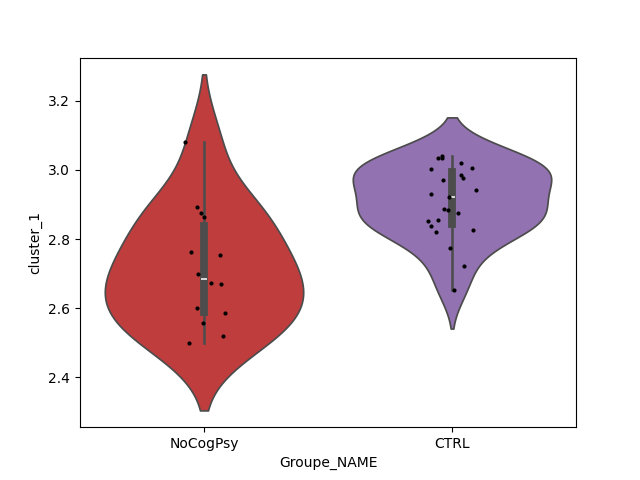

T-Test (oneside) : -3.832 and p_value = 0.001
  cluster_2 
/NAS/fatmike/Protocoles_3T/Neurosclerodermie/screenshots/sm_15/groups_compare_cluster_2_contrast1.png


/home/romain/SVN/python/romain/laBIBILaRORO.py:352: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_copy,y=name,x=groupUsed, palette=palette_copy,order=palette_copy.keys())


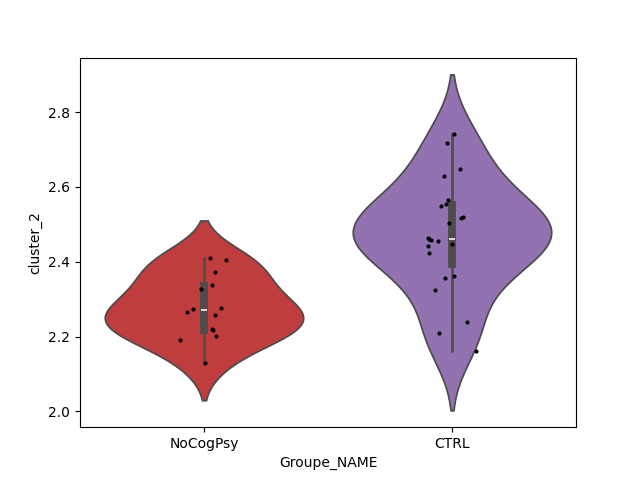

T-Test (oneside) : -4.951 and p_value = 0.000


In [22]:
reload(lbr)
pd.option_context('mode.use_inf_as_na', True)
for smoothing_fwhm in range(15, 26, 100):
    print(f"\033[1;31m******************************\n smooting à {smoothing_fwhm}\n***************************** \033[0m")  
    # Obtenez tous les couples possibles des valeurs uniques dans la colonne 'group'
    pairs = list(combinations(CLIData['Groupe_NAME'].dropna().unique(), 2))
    for pair in pairs: # Itérez sur tous les couples
        df_etude1_CT = pd.DataFrame(np.array(valCT[f"sm_{smoothing_fwhm}"]), index=CLIData.index)
        ssdf_CT = df_etude1_CT.loc[CLIData['Groupe_NAME'].isin([pair[0],pair[1]])]

            #Régression de l'age et du niveau d'education
            #lbr.regress_covar_func(df_etude1_CT.columns,var4Cov,ssdf_CT,merged_data.loc[merged_data[groupUsed].isin([pair[0],pair[1]])][var4Cov],True)

        ssdf_covar = CLIData.loc[ssdf_CT.index]

        # Construire le chemin du répertoire
        directory_path = os.path.join(STUDY_PATH, "screenshots", f"sm_{smoothing_fwhm}")

        # Créer le répertoire s'il n'existe pas
        os.makedirs(directory_path, exist_ok=True)
        lbr.grp_comp_surface_func('Groupe_NAME',var4Cov,ssdf_covar,ssdf_CT,directory_path,MyPalette=palette)

In [23]:
# Assuming read_surface is a function from brainspace.mesh.mesh_io
read_surface = mesh_io.read_surface

surf_lh = read_surface('/NAS/fatmike/Protocoles_3T/Neurosclerodermie/data/bids/derivatives/fastsurfer/sub-P0101_ses-1/surf/lh.inflated', itype='fs')
surf_rh = read_surface('/NAS/fatmike/Protocoles_3T/Neurosclerodermie/data/bids/derivatives/fastsurfer/sub-P0101_ses-1/surf/rh.inflated', itype='fs')


fileL = "/NAS/fatmike/Protocoles_3T/Neurosclerodermie/data/bids/derivatives/fastsurfer/sub-P0101_ses-1/label/lh.aparc_mics.annot"
fileR = "/NAS/fatmike/Protocoles_3T/Neurosclerodermie/data/bids/derivatives/fastsurfer/sub-P0101_ses-1/label/rh.aparc_mics.annot"
figPath = '/tmp/16428_micapipe_QC_P0101/sub-P0101_ses-1_atlas-aparc_desc-surf.png'
label = np.concatenate((nb.freesurfer.read_annot(fileL)[0], nb.freesurfer.read_annot(fileR)[0]), axis=0)


NameError: name 'mesh_io' is not defined

# Selection des regions dans HCP extension

In [16]:
# Filtrer les lignes où la colonne 'Lobe' est égale à 'Fr'
regions_fr = df_exthcp[df_exthcp['Lobe'] == 'Fr']

# Afficher les résultats
print(regions_fr)
regions_fr["Cortex_ID"].unique()
regions_fr["regionID"].unique()

    regionName                    regionLongName regionIdLabel LR region Lobe  \
7          4_L            Primary_Motor_Cortex_L           8_L  L      4   Fr   
9        FEF_L              Frontal_Eye_Fields_L          10_L  L    FEF   Fr   
10       PEF_L              Premotor_Eye_Field_L          11_L  L    PEF   Fr   
11       55b_L                        Area_55b_L          12_L  L    55b   Fr   
25       SFL_L  Superior_Frontal_Language_Area_L          26_L  L    SFL   Fr   
..         ...                               ...           ... ..    ...  ...   
345     pOFC_R           posterior_OFC_Complex_R         366_R  R   pOFC   Fr   
349     p10p_R              Area_posterior_10p_R         370_R  R   p10p   Fr   
350     p47r_R              Area_posterior_47r_R         371_R  R   p47r   Fr   
358    a32pr_R          Area_anterior_32_prime_R         379_R  R  a32pr   Fr   
359      p24_R               Area_posterior_24_R         380_R  R    p24   Fr   

                           

array([  8,  10,  11,  12,  26,  40,  41,  43,  44,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  96,
        97,  98,  99, 108, 111, 113, 115, 164, 165, 166, 169, 170, 171,
       179, 180, 208, 209, 210, 211, 212, 226, 240, 241, 243, 244, 253,
       254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
       267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279,
       280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292,
       293, 294, 296, 297, 298, 299, 308, 313, 364, 365, 366, 370, 371,
       379, 380])

# Atlas de Glasser

In [108]:
CLIData.index[0]

'P0101'

In [110]:
df_etude1_CT = pd.DataFrame(np.array(valCT[f"sm_{smoothing_fwhm}"]), index=CLIData.index)

In [126]:
region_ids = regions_fr["regionID"].unique()
mapped_ids = [val if val < 181 else val - 20 for val in region_ids]
print(mapped_ids)
plot_hemispheres(inflated_left,inflated_right,np.where(np.isin(glasser,mapped_ids),glasser, 0), color_bar=True,
        label_text=["Glasser"], cmap="jet", 
        embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)

roiCT = {f"{df_exthcp.iloc[value-1].regionLongName}": [] for value in mapped_ids}

valmoy=[]
for cpt in range(len(valCT['sm_15'])):
    valmoy.append(np.mean(valCT['sm_15'][cpt][np.where(np.isin(glasser,mapped_ids))]))

print(f"Selected regions :")
for value in mapped_ids:
    print(f"value  : \t{df_exthcp.iloc[value-1].regionLongName}")
    # Obtenir les indices où glasser est égal à la valeur courante
    for cpt in range(len(valCT['sm_15'])):
        roiCT[df_exthcp.iloc[value-1].regionLongName].append(np.mean(valCT['sm_15'][cpt][np.where(glasser == value)]))


[8, 10, 11, 12, 26, 40, 41, 43, 44, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 108, 111, 113, 115, 164, 165, 166, 169, 170, 171, 179, 180, 188, 189, 190, 191, 192, 206, 220, 221, 223, 224, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 276, 277, 278, 279, 288, 293, 344, 345, 346, 350, 351, 359, 360]
Selected regions :
value  : 	Primary_Motor_Cortex_L
value  : 	Frontal_Eye_Fields_L
value  : 	Premotor_Eye_Field_L
value  : 	Area_55b_L
value  : 	Superior_Frontal_Language_Area_L
value  : 	Dorsal_Area_24d_L
value  : 	Ventral_Area_24d_L
value  : 	Supplementary_and_Cingulate_Eye_Field_L
value  : 	Area_6m_anterior_L
value  : 	Area_3a_L
value  : 	Dorsal_area_6_L
value  : 	Area_6mp_L
value  : 	Vent

In [129]:
# On suppose que valmoy contient une valeur par sujet (même ordre que CLIData)
df_result = CLIData.copy()
df_result["frontalLobe"] = valmoy  # Ajoute la colonne des moyennes

# Pour roiCT, chaque clé est une région, chaque valeur est une liste (une valeur par sujet)
for region_name, values in roiCT.items():
    df_result[region_name] = values  # Ajoute chaque région comme colonne

# Afficher le résultat
print(df_result.head())

    # sum_mask = np.sum(volume_mask_weighted[indices])
    # if  sum_mask/len(indices[0]) >2.5:
        # roi_list_glasser.append(value)
    #print(f"\t{df_exthcp.iloc[value].regionLongName} ({lbr.ansi_colors20[len(roi_list_glasser)]} {lbr.BOLD} {len(roi_list_glasser)} {value} {lbr.RESET}) ")# : {len(indices[0])},{np.round(sum_mask,0)}, {sum_mask/len(indices[0])}")


        Groupe  AGE   IMC Groupe_NAME  frontalLobe  Primary_Motor_Cortex_L  \
SUBJID                                                                       
P0101        0   63  32.0  NoCogNoPsy     2.434510                2.451887   
P0102        1   57  26.0    CogNoPsy     2.620571                2.676563   
P0104        3   51  33.0      CogPsy     2.403903                2.267739   
P0105        2   59  30.0    NoCogPsy     2.475527                2.506359   
P0107        0   63  18.0  NoCogNoPsy     2.733894                2.861354   

        Frontal_Eye_Fields_L  Premotor_Eye_Field_L  Area_55b_L  \
SUBJID                                                           
P0101               2.344633              2.338263    2.390155   
P0102               2.618993              2.615011    2.699904   
P0104               2.551576              2.229976    2.576747   
P0105               2.569200              2.326462    2.674048   
P0107               2.727740              2.795430    2.7

/tmp/ipykernel_2328727/2640264975.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_result[region_name] = values  # Ajoute chaque région comme colonne
/tmp/ipykernel_2328727/2640264975.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_result[region_name] = values  # Ajoute chaque région comme colonne
/tmp/ipykernel_2328727/2640264975.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at onc

'f'

In [144]:
import plotly.express as px

# Sélectionne les colonnes numériques à afficher (sauf exclusions)
exclude_cols = ["Groupe", "AGE", "IMC", "Groupe_NAME"]
num_cols = [col for col in df_result.select_dtypes(include='number').columns if col not in exclude_cols]

#for col in num_cols[0]:
fig = px.box(df_result, x="Groupe_NAME", y='frontalLobe', points="all", hover_data=[df_result.index], title=f"Boxplot de {col} par Groupe_NAME")
fig.show()

In [160]:
import pingouin as pg
from scipy.stats import ttest_ind
from itertools import combinations
from statsmodels.stats.multitest import fdrcorrection

col='frontalLobe'
#for col in num_cols[0]:
print(f"\n--- {col} ---")
# ANOVA
aov = pg.anova(data=df_result, dv=col, between="Groupe_NAME", detailed=True)
print("ANOVA p-value :", aov['p-unc'].values[0])
pvals = []
comparaisons = []
# Comparaisons deux à deux (t-test)
groupes = df_result["Groupe_NAME"].dropna().unique()
for g1, g2 in combinations(groupes, 2):
    vals1 = df_result[df_result["Groupe_NAME"] == g1][col].dropna()
    vals2 = df_result[df_result["Groupe_NAME"] == g2][col].dropna()
    t_stat, p_val = ttest_ind(vals1, vals2, equal_var=False)
    pvals.append(p_val)
    comparaisons.append(f"{g1} vs {g2}")

# Correction FDR
reject, pvals_fdr = fdrcorrection(pvals)
for i, comp in enumerate(comparaisons):
    print(f"T-test {comp} : p={pvals[i]:.4f} | p-FDR={pvals_fdr[i]:.4f} | reject={reject[i]}")


--- frontalLobe ---
ANOVA p-value : 0.01397487246464487
T-test NoCogNoPsy vs CogNoPsy : p=0.2744 | p-FDR=0.4445 | reject=False
T-test NoCogNoPsy vs CogPsy : p=0.0022 | p-FDR=0.0123 | reject=True
T-test NoCogNoPsy vs NoCogPsy : p=0.0216 | p-FDR=0.0590 | reject=False
T-test NoCogNoPsy vs CTRL : p=0.8278 | p-FDR=0.8278 | reject=False
T-test CogNoPsy vs CogPsy : p=0.2055 | p-FDR=0.4110 | reject=False
T-test CogNoPsy vs NoCogPsy : p=0.4379 | p-FDR=0.5474 | reject=False
T-test CogNoPsy vs CTRL : p=0.3111 | p-FDR=0.4445 | reject=False
T-test CogPsy vs NoCogPsy : p=0.5846 | p-FDR=0.6496 | reject=False
T-test CogPsy vs CTRL : p=0.0025 | p-FDR=0.0123 | reject=True
T-test NoCogPsy vs CTRL : p=0.0236 | p-FDR=0.0590 | reject=False


In [ ]:
import pingouin as pg
from scipy.stats import ttest_ind
from itertools import combinations
import statsmodels.api as sm

col='frontalLobe'

print(f"\n--- {col} (résidu AGE+IMC) ---")
# Régression linéaire pour retirer AGE et IMC
X = df_result[["AGE","IMC"]]
X = sm.add_constant(X)
y = df_result[col]
model = sm.OLS(y, X, missing='drop').fit()
residus = model.resid

# Crée un DataFrame temporaire pour les tests
df_tmp = df_result.copy()
df_tmp[f"{col}_resid"] = residus

# ANOVA sur les résidus
aov = pg.anova(data=df_tmp, dv=f"{col}_resid", between="Groupe_NAME", detailed=True)
print("ANOVA p-value :", aov['p-unc'].values[0])

pvals = []
comparaisons = []

# T-tests sur les résidus
groupes = df_tmp["Groupe_NAME"].dropna().unique()
for g1, g2 in combinations(groupes, 2):
    vals1 = df_tmp[df_tmp["Groupe_NAME"] == g1][f"{col}_resid"].dropna()
    vals2 = df_tmp[df_tmp["Groupe_NAME"] == g2][f"{col}_resid"].dropna()
    t_stat, p_val = ttest_ind(vals1, vals2, equal_var=False)
    # print(f"T-test {g1} vs {g2} : p={p_val:.4f}")
    pvals.append(p_val)
    comparaisons.append(f"{g1} vs {g2}")

# Correction FDR
reject, pvals_fdr = fdrcorrection(pvals)
for i, comp in enumerate(comparaisons):
    print(f"T-test {comp} : p={pvals[i]:.4f} | p-FDR={pvals_fdr[i]:.4f} | reject={reject[i]}")



--- frontalLobe (résidu AGE+IMC) ---
ANOVA p-value : 0.05670880965739941
T-test NoCogNoPsy vs CogNoPsy : p=0.3073 | p-FDR=0.4956 | reject=False
T-test NoCogNoPsy vs CogPsy : p=0.0062 | p-FDR=0.0337 | reject=True
T-test NoCogNoPsy vs NoCogPsy : p=0.0581 | p-FDR=0.1625 | reject=False
T-test NoCogNoPsy vs CTRL : p=0.8408 | p-FDR=0.8408 | reject=False
T-test CogNoPsy vs CogPsy : p=0.2865 | p-FDR=0.4956 | reject=False
T-test CogNoPsy vs NoCogPsy : p=0.5636 | p-FDR=0.6787 | reject=False
T-test CogNoPsy vs CTRL : p=0.3469 | p-FDR=0.4956 | reject=False
T-test CogPsy vs NoCogPsy : p=0.6109 | p-FDR=0.6787 | reject=False
T-test CogPsy vs CTRL : p=0.0067 | p-FDR=0.0337 | reject=True
T-test NoCogPsy vs CTRL : p=0.0650 | p-FDR=0.1625 | reject=False
